In [1]:
from IPython.display import clear_output

!pip install -U "ray[rllib]"
!pip install tianshou
!pip install "stable-baselines3[extra]>=2.0.0a4"
!pip install mat4py

clear_output()

# LIBPackEnv

/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


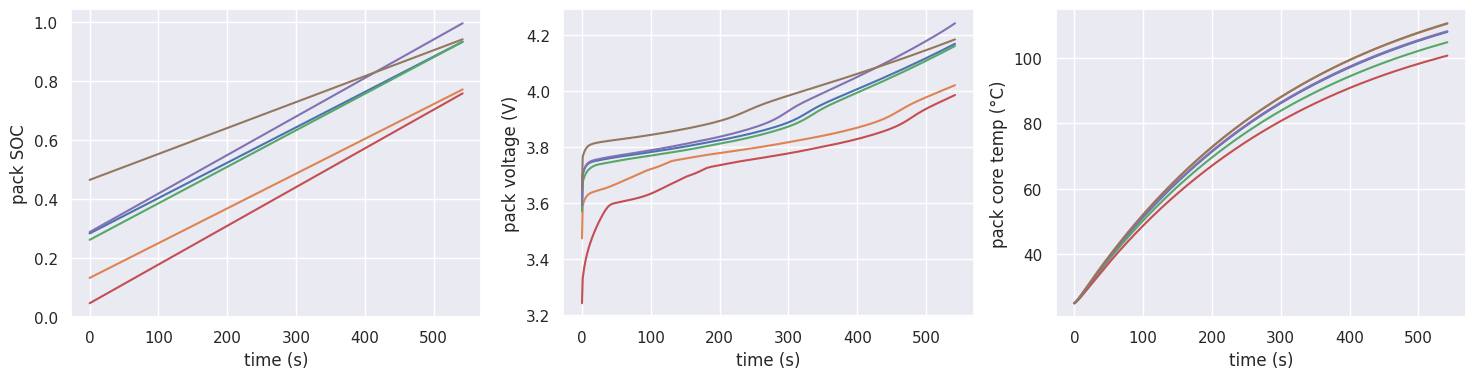

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from LIBEnv.LIB_gym import LIBPackEnv
import seaborn as sns
sns.set_theme()

env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1, use_switch=False)

pack_res=[]
rewards = []
pack_res.append(env.reset(0)[0].reshape(3,6))
done = False
while not done:
    next_state, reward, done, _, info = env.step(np.ones(7))
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)

pack_res = np.array(pack_res)
plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.plot(pack_res[:,0,:])
plt.xlabel('time (s)')
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(1,3,2)
plt.plot(pack_res[:,1,:]*(env.max_voltage-env.min_voltage)+env.min_voltage)
plt.xlabel('time (s)')
plt.ylabel('pack voltage (V)')
plt.grid('on')
plt.subplot(1,3,3)
plt.plot(pack_res[:,2,:]*env.T)
plt.xlabel('time (s)')
plt.ylabel('pack core temp (°C)')
plt.grid('on')

# Ray

In [ ]:
import ray
from ray import tune
from ray.rllib.algorithms.ppo import PPOConfig
from ray.tune.registry import register_env
import os

chkpt_root ='./'
register_env("LIBPackEnv", lambda config: LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1))

ray.init(num_gpus=1, ignore_reinit_error=True)

config = (  # 1. Configure the algorithm,
    PPOConfig()
    .environment("LIBPackEnv")
    # .rollouts(num_rollout_workers=2)
    .framework("torch")
    .training(model={"fcnet_hiddens": [32, 32, 32]}, gamma=0.95)
    # .evaluation(evaluation_num_workers=1)
    .resources(num_gpus=1)
)

agent = config.build()

output_dir= "ray_models"
best_reward = -float("inf")
best_checkpoint = None
RETURNS = []
LENGTHS = []

n_episodes = 1000
current_episode = 0
total_episodes = 0

for i in range(n_episodes):

    while total_episodes == current_episode:
        result = agent.train()
        total_episodes = result["episodes_total"]
    current_episode = total_episodes

    reward = result["episode_reward_mean"]
    length = result["episode_len_mean"]
    RETURNS.append(reward)
    LENGTHS.append(length)
    if reward > best_reward:
        best_reward = reward
        best_checkpoint = agent.save(os.path.join(output_dir, "_best"))
    checkpoint = agent.save(os.path.join(output_dir, "_checkpoint"))
    print(f"Episode {i}: R: {reward:.2f}, L: {length:.2f} || Best R: {best_reward:.2f}")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/tensorflow/python/framework/dtypes.py:35: DeprecationWarning: ml_dtypes.float8_e4m3b11 is deprecated. Use ml_dtypes.float8_e4m3b11fnuz
  from tensorflow.tsl.python.lib.core import pywrap_ml_dtypes
/usr/local/lib/python3.10/dist-packages/flax/configurations.py:42: DeprecationWarning: jax.config.define_bool_state is deprecated. Please use other libraries for configuration instead.
  return jax_config.define_bool_state('flax_' + name, default, help)
/usr/local/lib/python3.10/dist-packages/tensorflow_probability/python/__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use pa

Episode 0: R: -20930.40, L: 1000.50 || Best R: -20930.40
Episode 1: R: -23339.90, L: 1099.67 || Best R: -20930.40
Episode 2: R: -23417.32, L: 1059.30 || Best R: -20930.40
Episode 3: R: -24308.05, L: 1072.36 || Best R: -20930.40
Episode 4: R: -22850.53, L: 1045.11 || Best R: -20930.40
Episode 5: R: -22216.63, L: 1036.32 || Best R: -20930.40
Episode 6: R: -21503.78, L: 1043.38 || Best R: -20930.40
Episode 7: R: -20503.52, L: 1019.40 || Best R: -20503.52
Episode 8: R: -20516.06, L: 1028.91 || Best R: -20503.52
Episode 9: R: -20276.75, L: 1040.00 || Best R: -20276.75
Episode 10: R: -19715.89, L: 1029.24 || Best R: -19715.89
Episode 11: R: -19384.35, L: 1031.09 || Best R: -19384.35
Episode 12: R: -18988.72, L: 1018.30 || Best R: -18988.72
Episode 13: R: -18792.94, L: 1019.28 || Best R: -18792.94
Episode 14: R: -18331.42, L: 1007.98 || Best R: -18331.42
Episode 15: R: -18307.66, L: 1018.73 || Best R: -18307.66
Episode 16: R: -18035.57, L: 1024.18 || Best R: -18035.57
Episode 17: R: -17677.24

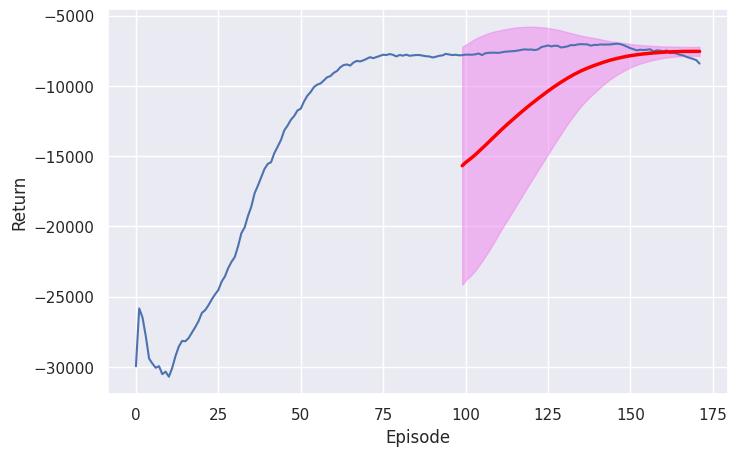

In [5]:
import pandas as pd
returns = np.array(RETURNS).ravel()

window = 10
rolling_mean = pd.Series(returns).rolling(window).mean()
std = pd.Series(returns).rolling(window).std()

plt.figure(figsize=(8,5))
plt.plot(returns)
plt.plot(rolling_mean, color='red', linewidth=2.5)
plt.fill_between(range(len(rolling_mean)),rolling_mean-std, rolling_mean+std, color='violet', alpha=0.5)

plt.xlabel('Episode')
plt.ylabel('Return')
plt.grid('on')

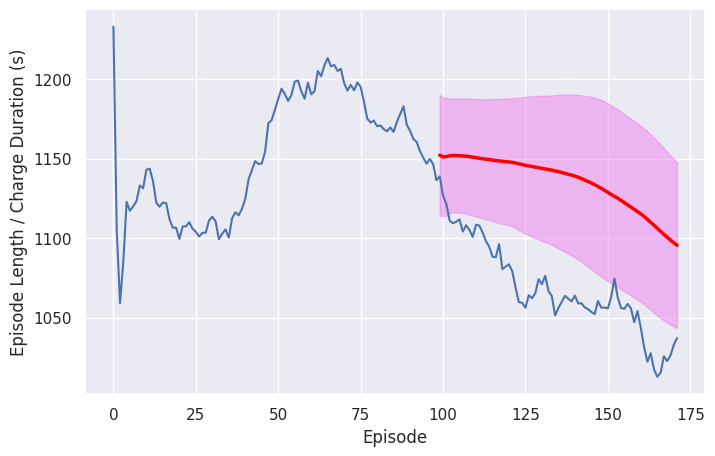

In [6]:
import pandas as pd
returns = np.array(LENGTHS).ravel()

window = 10
rolling_mean = pd.Series(returns).rolling(window).mean()
std = pd.Series(returns).rolling(window).std()

plt.figure(figsize=(8,5))
plt.plot(returns)
plt.plot(rolling_mean, color='red', linewidth=2.5)
plt.fill_between(range(len(rolling_mean)),rolling_mean-std, rolling_mean+std, color='violet', alpha=0.5)

plt.xlabel('Episode')
plt.ylabel('Episode Length / Charge Duration (s)')
plt.grid('on')

In [ ]:
# !tensorboard --logdir=$HOME/ray_results

^C


### Evaluation

2023-12-10 21:06:52,798	INFO trainable.py:585 -- Restored on 172.28.0.12 from checkpoint: Checkpoint(filesystem=local, path=ray_models/_checkpoint)
/usr/local/lib/python3.10/dist-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


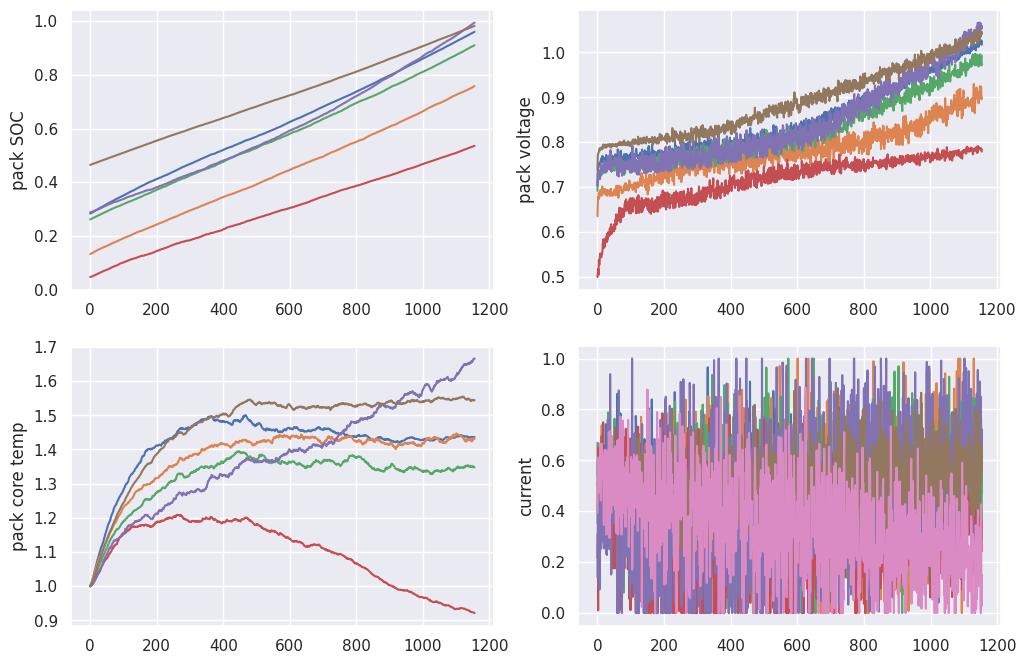

In [7]:
agent.restore(checkpoint)

env = LIBPackEnv('./LIBEnv/PANmodel.mat', number_of_cells=6, T=25, dt=1)
state, _ = env.reset(0)

pack_res=[]
rewards = []
actions = []

done = False
pack_res.append(state.reshape(3,6))
while not done:
    action = agent.compute_single_action(state)
    next_state, reward, done, _, info = env.step(action)
    state = next_state
    pack_res.append(next_state.reshape(3,6))
    rewards.append(reward)
    actions.append(action)

pack_res = np.array(pack_res)
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.plot(pack_res[:-1,0,:])
plt.ylabel('pack SOC')
plt.grid('on')
plt.subplot(2,2,2)
plt.plot(pack_res[:-1,1,:])
plt.ylabel('pack voltage')
plt.grid('on')
plt.subplot(2,2,3)
plt.plot(pack_res[:-1,2,:])
plt.ylabel('pack core temp')
plt.grid('on')
plt.subplot(2,2,4)
plt.plot(np.array(actions)[:-1].reshape(-1,7))
plt.ylabel('current')
plt.grid('on')